# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
def build_teacher():
  # Build CNN teacher.
  cnn_model = tf.keras.Sequential()

  # your code start from here for stpe 2
  cnn_model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
  cnn_model.add(tf.keras.layers.MaxPool2D((2, 2), strides=1))
  cnn_model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
  cnn_model.add(tf.keras.layers.MaxPool2D((2, 2), strides=2))
  cnn_model.add(tf.keras.layers.Flatten())
  cnn_model.add(tf.keras.layers.Dropout(0.5))
  cnn_model.add(tf.keras.layers.Dense(128, 'relu'))
  cnn_model.add(tf.keras.layers.Dropout(0.5))
  cnn_model.add(tf.keras.layers.Dense(NUM_CLASSES))
  return cnn_model


# Build fully connected student.
def build_student():
  fc_model = tf.keras.Sequential()


  # your code start from here for step 2
  fc_model.add(tf.keras.layers.Flatten())
  fc_model.add(tf.keras.layers.Dense(784, 'relu'))
  fc_model.add(tf.keras.layers.Dense(784, 'relu'))
  fc_model.add(tf.keras.layers.Dense(NUM_CLASSES))
  return fc_model

cnn_model = build_teacher()
fc_model = build_student()

# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)


  return cross_entropy_loss_value

# Student loss function

In [ ]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.keras.activations.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = (1 - ALPHA) * distillation_loss_value + ALPHA * tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)

  return cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = opt = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

def evaluate(model):
  num_correct = 0
  num_total = builder.info.splits['test'].num_examples
  for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
  print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/ece1512/projectB')

Mounted at /content/drive


# Training models

In [ ]:
# your code start from here for step 5 
train_and_evaluate(cnn_model, compute_teacher_loss)
# cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_cnn.h5')
DISTILLATION_TEMPERATURE = 4
train_and_evaluate(fc_model, compute_student_loss)
cnn_model.save("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_cnn.h5")
fc_model.save("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_studentfc.h5")

Epoch 1: Class_accuracy: 96.82%
Epoch 2: Class_accuracy: 97.74%
Epoch 3: Class_accuracy: 98.10%
Epoch 4: Class_accuracy: 98.42%
Epoch 5: Class_accuracy: 98.74%
Epoch 6: Class_accuracy: 98.50%
Epoch 7: Class_accuracy: 98.69%
Epoch 8: Class_accuracy: 98.65%
Epoch 9: 

KeyboardInterrupt: ignored

# Test accuracy vs. tempreture curve

Class_accuracy: 99.17%
Epoch 1: Class_accuracy: 96.52%
Epoch 2: Class_accuracy: 97.34%
Epoch 3: Class_accuracy: 97.78%
Epoch 4: Class_accuracy: 97.87%
Epoch 5: Class_accuracy: 98.17%
Epoch 6: Class_accuracy: 98.04%
Epoch 7: Class_accuracy: 97.82%
Epoch 8: Class_accuracy: 98.17%
Epoch 9: Class_accuracy: 98.27%
Epoch 10: Class_accuracy: 98.31%
Epoch 11: Class_accuracy: 98.10%
Epoch 12: Class_accuracy: 98.18%


Epoch 1: Class_accuracy: 96.49%
Epoch 2: Class_accuracy: 97.81%
Epoch 3: Class_accuracy: 98.01%
Epoch 4: Class_accuracy: 98.18%
Epoch 5: Class_accuracy: 98.47%
Epoch 6: Class_accuracy: 98.34%
Epoch 7: Class_accuracy: 98.47%
Epoch 8: Class_accuracy: 98.52%
Epoch 9: Class_accuracy: 98.67%
Epoch 10: Class_accuracy: 98.46%
Epoch 11: Class_accuracy: 98.16%
Epoch 12: Class_accuracy: 98.61%


Epoch 1: Class_accuracy: 96.55%
Epoch 2: Class_accuracy: 97.87%
Epoch 3: Class_accuracy: 98.26%
Epoch 4: Class_accuracy: 98.51%
Epoch 5: Class_accuracy: 98.50%
Epoch 6: Class_accuracy: 98.63%
Epoch 7: Class_accuracy: 98.65%
Epoch 8: Class_accuracy: 98.71%
Epoch 9: Class_accuracy: 98.74%
Epoch 10: Class_accuracy: 98.77%
Epoch 11: Class_accuracy: 98.77%
Epoch 12: Class_accuracy: 98.83%


Epoch 1: Class_accuracy: 96.89%
Epoch 2: Class_accuracy: 97.87%
Epoch 3: Class_accuracy: 98.24%
Epoch 4: Class_accuracy: 98.43%
Epoch 5: Class_accuracy: 98.54%
Epoch 6: Class_accuracy: 98.62%
Epoch 7: Class_accuracy: 98.62%
Epoch 8: Class_accuracy: 98.65%
Epoch 9: Class_accuracy: 98.74%
Epoch 10: Class_accuracy: 98.83%
Epoch 11: Class_accuracy: 98.73%
Epoch 12: Class_accuracy: 98.88%


Epoch 1: Class_accuracy: 96.83%
Epoch 2: Class_accuracy: 97.87%
Epoch 3: Class_accuracy: 98.27%
Epoch 4: Class_accuracy: 98.41%
Epoch 5: Class_accuracy: 98.55%
Epoch 6: Class_accuracy: 98.59%
Epoch 7: Class_accuracy: 98.65%
Epoch 8: Class_accuracy: 98.75%
Epoch 9: Class_accuracy: 98.69%
Epoch 10: Class_accuracy: 98.77%
Epoch 11: Class_accuracy: 98.84%
Epoch 12: Class_accuracy: 98.87%


Epoch 1: Class_accuracy: 96.86%
Epoch 2: Class_accuracy: 97.86%
Epoch 3: Class_accuracy: 98.17%
Epoch 4: Class_accuracy: 98.35%
Epoch 5: Class_accuracy: 98.61%
Epoch 6: Class_accuracy: 98.64%
Epoch 7: Class_accuracy: 98.69%
Epoch 8: Class_accuracy: 98.69%
Epoch 9: Class_accuracy: 98.78%
Epoch 10: Class_accuracy: 98.83%
Epoch 11: Class_accuracy: 98.82%
Epoch 12: Class_accuracy: 98.80%


T = 1


Class_accuracy: 98.18%
T = 2


Class_accuracy: 98.61%
T = 4


Class_accuracy: 98.83%
T = 16


Class_accuracy: 98.88%
T = 32


Class_accuracy: 98.87%
T = 64


Class_accuracy: 98.80%


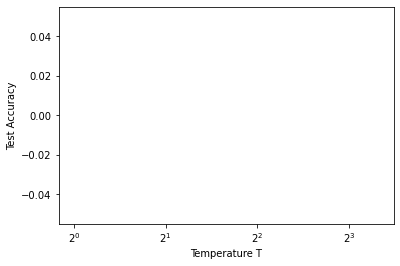

In [ ]:
import matplotlib.pyplot as plt
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_cnn.h5')
evaluate(cnn_model)
# your code start from here for step 6
for t in [1, 2, 4, 16, 32, 64]:
  DISTILLATION_TEMPERATURE = t
  fc_model = build_student()
  train_and_evaluate(fc_model, compute_student_loss)
  fc_model.save("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_student_T_{}.h5".format(t))
y = []
for t in [1, 2, 4, 16, 32, 64]:
  print("T = " + str(t))
  fc_model = build_student()
  fc_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_student_T_{}.h5".format(t))
  acc = evaluate(fc_model)
  y.append(acc)

plt.plot([1,2,4,16,32,64], y)
plt.xlabel("Temperature T")
plt.xscale('log', basex=2)
plt.ylabel("Test Accuracy")
plt.savefig("Temperature vs test accuracy.png")


# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = build_student()

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
  
  return cross_entropy_loss

train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: 

KeyboardInterrupt: ignored

In [ ]:
fc_model_no_distillation.save("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_fc_no_distillation.h5")

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
# your code start from here for step 8
!pip install keras_flops
from keras_flops import get_flops
flops = get_flops(cnn_model, batch_size=1)
print(f"Teacher FLOPs: {flops / 10 ** 9:.03} G")
print(cnn_model.summary())
flops = get_flops(fc_model, batch_size=1)
print(f"Student FLOPs: {flops / 10 ** 9:.03} G")
print(fc_model.summary())

     |████████████████████████████████| 462 kB 3.2 MB/s 
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Teacher FLOPs: 0.022 G
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 7744)              0         
                                                                 
 dropout_6 (Dropout)         (N

# XAI method to explain models

In [ ]:
# your code start from here for step 9
import numpy as np
from PIL import Image, ImageDraw
def smooth_grad(input_model, image, n, noise_level):
  cls = np.argmax(input_model.predict(image))
  smooth_grads = np.zeros_like(image)
  std = np.sqrt(noise_level * (np.max(image) - np.min(image)))
  feedforward = tf.keras.models.Model(input_model.input, input_model.output)
  i = 0
  j = 0
  while i < n:
    noise_input = image + np.random.normal(0, std, image.shape)
    noise_input = tf.Variable(noise_input, dtype=tf.float32)
    with tf.GradientTape() as tape:
      preds = feedforward([noise_input])
      noise_label = np.argmax(preds)
      loss = preds[:, cls]
    if noise_label == cls:
      grads = tape.gradient(loss, noise_input)
      smooth_grads += grads
      j += 1
    i += 1
  smooth_grads /= j
  return smooth_grads[0,:,:].numpy()


fc_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_student_T_4.h5")
all_labels_images = []
found_labels = set()
evaluate(fc_model)
evaluate(fc_model_no_distillation)
for images, labels in mnist_test:
  for i in range(images.shape[0]):
    if tf.argmax(labels[i]).numpy() not in found_labels:
      all_labels_images.append(images[i])
      found_labels.add(tf.argmax(labels[i]).numpy())
  if len(found_labels) == 10:
    break

all_labels_images = tf.convert_to_tensor(all_labels_images)
print(all_labels_images.shape)

for i in range(all_labels_images.shape[0]):
  input = tf.expand_dims(all_labels_images[i], 0)
  teacher_explanation = smooth_grad(cnn_model, input, 100, 0.1)
  teacher_explanation -= teacher_explanation.min()
  teacher_explanation /= teacher_explanation.max()+10e-30
  teacher_explanation = tf.squeeze(teacher_explanation)

  student_explanation = smooth_grad(fc_model, input, 100, 0.1)
  student_explanation -= student_explanation.min()
  student_explanation /= student_explanation.max()+10e-30
  student_explanation = tf.squeeze(student_explanation)

  student_nodistill_explanation = smooth_grad(fc_model_no_distillation, input, 100, 0.1)
  student_nodistill_explanation -= student_nodistill_explanation.min()
  student_nodistill_explanation /= student_nodistill_explanation.max()+10e-30
  student_nodistill_explanation = tf.squeeze(student_nodistill_explanation)

  input = tf.squeeze(input)
  plt.figure(figsize=(20,5))
  plt.subplot(1,4,1)
  plt.imshow(input)
  plt.axis('off')
  plt.title('Sample image')

  plt.subplot(1,4,2)
  plt.imshow(input)
  plt.imshow(teacher_explanation, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Teacher Explanation map')

  plt.subplot(1,4,3)
  plt.imshow(input)
  plt.imshow(student_explanation, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Student Explanation map')

  plt.subplot(1,4,4)
  plt.imshow(input)
  plt.imshow(student_nodistill_explanation, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.title('Student no distill Explanation map')


# Implementing the state-of-the-art KD algorithm

In [ ]:
def first_stage_training(teacher, student):
  optimizer = opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  hint = tf.keras.models.Model(teacher.input, teacher.layers[4].output)
  guided = tf.keras.models.Model(student.input, student.layers[1].output)
  W_r = tf.keras.layers.Dense(7744, trainable=True)
  mse = tf.keras.losses.MeanSquaredError()
  for layer in student.layers:
    layer.trainable = False
  student.layers[1].trainable = True
  for epoch in range(1, NUM_EPOCHS + 1):
    print("Epoch {}: ".format(epoch), end='')
    L = 0
    i = 0
    for images, labels in mnist_train:
      with tf.GradientTape(persistent=True) as tape:
        hint_output = hint(images)
        guided_output = W_r(guided(images))
        loss = mse(hint_output, guided_output)
        L += loss
      model_grads = tape.gradient(loss, student.trainable_variables)
      regressor_grads = tape.gradient(loss, W_r.trainable_variables)
      del tape
      optimizer.apply_gradients(zip(model_grads, student.trainable_variables))
      optimizer.apply_gradients(zip(regressor_grads, W_r.trainable_variables))
      i += 1
    print(" {}".format(L / i))
cnn_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_cnn.h5")
fc_model = build_student()
fc_model.build(input_shape=(1,28,28))
first_stage_training(cnn_model, fc_model)
fc_model.save("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_fitnet_stage1.h5")
evaluate(fc_model)

Epoch 1:  0.010677407495677471
Epoch 2:  0.005648130550980568
Epoch 3:  0.004715459421277046
Epoch 4:  0.004221356473863125
Epoch 5:  0.0039020690601319075
Epoch 6:  0.0036757206544280052
Epoch 7:  0.003506530774757266
Epoch 8:  0.0033732547890394926
Epoch 9:  0.0032668611966073513
Epoch 10:  0.0031834226101636887
Epoch 11:  0.0031115675810724497
Epoch 12:  0.003050887957215309


Class_accuracy: 8.31%


In [ ]:
fc_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_fitnet_stage1.h5")
ALPHA=0.5
DISTILLATION_TEMPERATURE=16
for layer in fc_model.layers:
  layer.trainable = True
train_and_evaluate(fc_model, compute_student_loss)
fc_model.save("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/mnist_fitnet_stage2.h5")

Epoch 1: WARNING:tensorflow:Model was constructed with shape (1, 28, 28) for input KerasTensor(type_spec=TensorSpec(shape=(1, 28, 28), dtype=tf.float32, name='flatten_4_input'), name='flatten_4_input', description="created by layer 'flatten_4_input'"), but it was called on an input with incompatible shape (256, 28, 28).


Class_accuracy: 98.21%
Epoch 2: Class_accuracy: 98.45%
Epoch 3: Class_accuracy: 98.70%
Epoch 4: Class_accuracy: 98.68%
Epoch 5: Class_accuracy: 98.73%
Epoch 6: Class_accuracy: 98.83%
Epoch 7: Class_accuracy: 98.88%
Epoch 8: Class_accuracy: 98.83%
Epoch 9: Class_accuracy: 98.87%
Epoch 10: Class_accuracy: 98.90%
Epoch 11: Class_accuracy: 98.92%
Epoch 12: Class_accuracy: 98.94%
